## [Issues]
0. Data 가져오기
1. ID, Name and SSN (Not useful)
2. Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Amount_invested_monthly, Outstanding_Debt Credit_Mix, Monthly_Balance Numerical but show as catogery (need to be fixed)
3. Occupation, CreditMix has value "__"
4. Data contains outliers
5. Num_Credit_Card has zeros
6. Type_of_Loan Need to rewrite as 8 columns
7. Num_Bank_Accounts contains negative values
8. Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,'Credit_Mix' (needs Feature Engineering)
9. Target Columns is Imbalanced
10. A lot of missing data

# 0. 데이터 import

In [143]:
# Packages for EDA 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re 

# Modeling and evaluation 
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib

# Packages options 
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all 
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings 
warnings.filterwarnings("ignore")

In [48]:
import pandas as pd
import numpy as np

In [49]:
df = pd.read_csv('./train.csv')
df.head(3)

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_71707/232461899.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./train.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


In [3]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


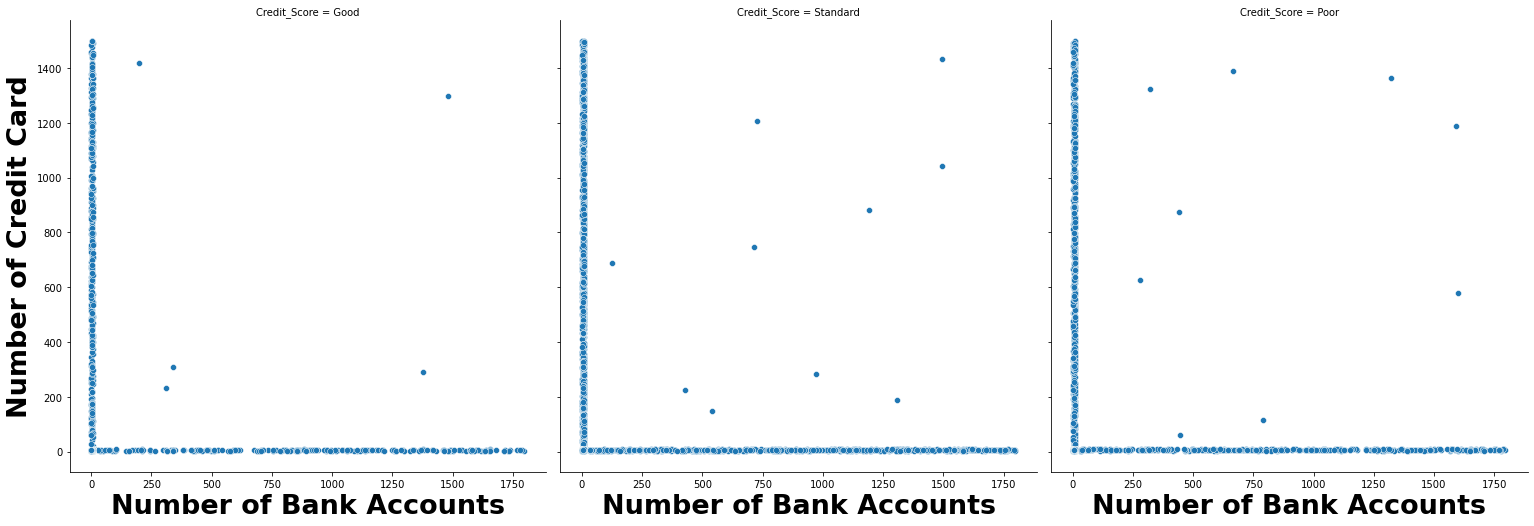

In [47]:
g = sns.relplot(
    data=df,
    x="Num_Bank_Accounts",
    y="Num_Credit_Card",
    col="Credit_Score",
    height=7,
    aspect=1,
)
g.set_axis_labels(
    "Number of Bank Accounts", "Number of Credit Card", size=27, fontweight="bold"
)
plt.show()

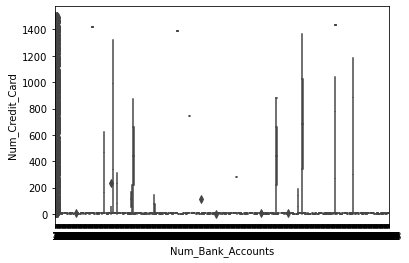

In [46]:
import matplotlib.pyplot as plt
plt.figure()
sns.boxplot(data=df,x="Num_Bank_Accounts" ,y='Num_Credit_Card')
plt.show()

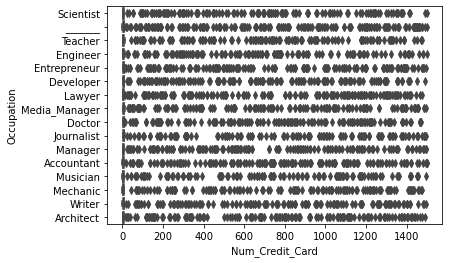

In [18]:
import matplotlib.pyplot as plt
plt.figure()
sns.boxplot(data=df,x="Num_Credit_Card" ,y='Occupation')
plt.show()

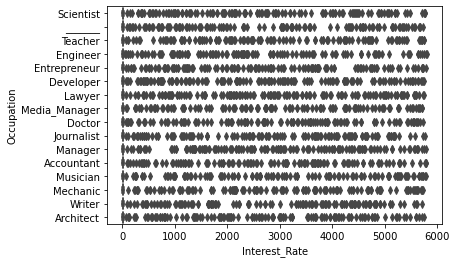

In [19]:
import matplotlib.pyplot as plt
plt.figure()
sns.boxplot(data=df,x="Interest_Rate" ,y='Occupation')
plt.show()

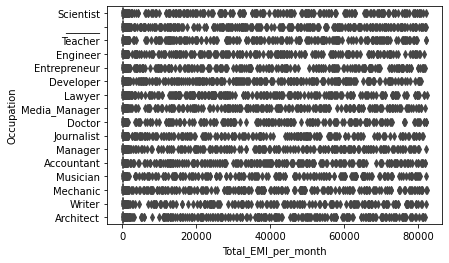

In [20]:
import matplotlib.pyplot as plt
plt.figure()
sns.boxplot(data=df,x="Total_EMI_per_month" ,y='Occupation')
plt.show()

---

# 2. 전처리

In [23]:
# df.columns
df = df.drop(["ID", "Name", "SSN"], axis=1) # 종속변인+중복컬럼 제외

# X = StandardScaler().fit_transform(X) <- 정규화는 나중에! 중요도평가할 때 음수값 있으면 안됌

결측치 확인 및 imputation

In [24]:
# X.head(2)
df.info() # 여기서 object를 int, float으로 바꿔야함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  object 
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  object 
 5   Monthly_Inhand_Salary     84998 non-null   float64
 6   Num_Bank_Accounts         100000 non-null  int64  
 7   Num_Credit_Card           100000 non-null  int64  
 8   Interest_Rate             100000 non-null  int64  
 9   Num_of_Loan               100000 non-null  object 
 10  Type_of_Loan              88592 non-null   object 
 11  Delay_from_due_date       100000 non-null  int64  
 12  Num_of_Delayed_Payment    92998 non-null   object 
 13  Changed_Credit_Limit      100000 non-null  ob

언더바 있는 값 처리

In [25]:
N_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

def fix_nums(num):
    try : 
        return float(num.replace("_",""))
    except :
        return np.nan
    
for col in N_to_fix :
    df[col] = df[col].apply(fix_nums)

대출유형 컬럼나누기
- 모든 대출유형은 서로 다른 9개의 대출의 조합으로 이루어진다.
- 그래서 컬럼 9개를 만들어 각 행데이터마다 해당 대출을 갖고있는지에 대해 false(안가짐), true(가짐) 처리.
- 위 수행 후 기존 대출유형 컬럼 삭제

In [26]:
# X["Type_of_Loan"].value_counts().sum()
df["Type_of_Loan"].value_counts().head(9)

Not Specified              1408
Credit-Builder Loan        1280
Personal Loan              1272
Debt Consolidation Loan    1264
Student Loan               1240
Payday Loan                1200
Mortgage Loan              1176
Auto Loan                  1152
Home Equity Loan           1136
Name: Type_of_Loan, dtype: int64

In [27]:
for i in df['Type_of_Loan'].value_counts().head(9).index[1:] : 
    df[i] = df['Type_of_Loan'].str.contains(i)

del df['Type_of_Loan']

마이너스 값 처리

In [28]:
df.describe()
# min값에 Num_Bank_Accounts만 음수임. 음수 존재.
# Num_Credit_Card가 0 일 수 없음 -> 최소 1개이니 0을 1로 대체

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,9.713200e+04
mean,110.649700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,1403.118217,637.412998,-3.088580e+22
std,686.244717,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8306.041270,2043.319327,3.208492e+24
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,-3.333333e+26
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,74.534002,2.699858e+02
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,135.925682,3.364493e+02
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,265.731733,4.696405e+02
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1.602041e+03


In [29]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x :abs (x)) #절댓값으로 변환
df['Num_Bank_Accounts'].describe()

count    100000.000000
mean         17.091700
std         117.404773
min           0.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64

In [30]:
# 은행, 카드 갯수 0을 1개로
df['Num_Bank_Accounts'].replace(0,1,inplace=True)
df['Num_Credit_Card'].replace(0,1,inplace=True)

'Credit_History_Age' 컬럼은 잘모르겠음. 일단 결측치처리

In [31]:
def History_age(age):
    try : 
        years = int("".join(re.findall('[0-9]',''.join(age.split("and")[0]))))
        month = int("".join(re.findall('[0-9]',''.join(age.split("and")[1]))))
        return years*12 + month
    except :
        return np.nan
    
df['Credit_History_Age'] = df['Credit_History_Age'].apply(History_age)


"Payment_of_Min_Amount" 결측치 처리

In [32]:
df['Payment_of_Min_Amount'].value_counts()

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [33]:
df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)
df['Payment_of_Min_Amount'].value_counts()

Yes    52326
No     47674
Name: Payment_of_Min_Amount, dtype: int64

"Payment_Behaviour" 결측치 처리

In [34]:
df['Payment_Behaviour'].value_counts()
# 결측치 존재 -> "!@9#%8"

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [35]:
df['Payment_Behaviour']= df['Payment_Behaviour'].replace("!@9#%8",np.nan) # 결측치 처리
df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: Payment_Behaviour, dtype: int64

"Occupation" 결측치 처리 : "_______"

In [36]:
df['Occupation'].value_counts() # _______ 값 존재.

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [37]:
occs = df['Occupation'].value_counts().index[1:]
occs

Index(['Lawyer', 'Architect', 'Engineer', 'Scientist', 'Mechanic',
       'Accountant', 'Developer', 'Media_Manager', 'Teacher', 'Entrepreneur',
       'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'],
      dtype='object')

In [38]:
# 직업이 _____로 되어있는 칸이 있어서 같은 사람의 직업 데이터로 대체시켜준다.
for ID in df[df['Occupation'] == "_______"]['Customer_ID'] : 
    oc = df[df['Customer_ID'] == ID]['Occupation'].mode()[0]
    df[df['Customer_ID'] == ID] = df[df['Customer_ID'] == ID].replace("_______",oc)

In [39]:
df['Occupation'].value_counts()
# 대체 시켜줄 데이터가 없는 행이 5개 존재하기에 아래 코드 진행.

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
_______             5
Name: Occupation, dtype: int64

In [40]:
df['Occupation'] = df['Occupation'].replace("_______",df['Occupation'].mode()[0])
df['Occupation'].value_counts()
# "______" 대체, 제거 완료.

Lawyer           7101
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6715
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

'Credit_Mix' 결측치 처리

In [41]:
df['Credit_Mix'].value_counts() # _ 존재. np로 처리.

Standard    36479
Good        24337
_           20195
Bad         18989
Name: Credit_Mix, dtype: int64

In [42]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}

df['Credit_Mix'] = df['Credit_Mix'].map(m)

In [43]:
df['Credit_Mix'].value_counts()

1.0    36479
2.0    24337
0.0    18989
Name: Credit_Mix, dtype: int64

Missing Data를 같은 사람의 다른 데이터 평균 값으로 대체해주기(수치형, 스트링형 따로)

In [44]:
# Edit Columns from bool to int 
for col in list(df.columns[-8:]):
    df[col] = df[col].astype(float)
    
# 각 고객ID를 숫자(1~)로 변경
IDs = 1 
for ID in df['Customer_ID'].unique() :
    df['Customer_ID'] = df['Customer_ID'].replace(ID,IDs)
    IDs += 1

In [45]:
# KNNImputer를 사용하여 결측치를 근처에 있는 값의 평균으로 대체.(같은 사람 데이터 중)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

## 먼저 수치형 데이터 먼저
Numericals = df.select_dtypes(exclude='object').columns[1:]
Numericals

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit-Builder Loan',
       'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
       'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan'],
      dtype='object')

> # !!!!!!!!!!!!얘가문제

In [169]:
for col in Numericals[1:]:
    imputer.fit(df[['Customer_ID',col]])
    df[['Customer_ID',col]] = imputer.transform(df[['Customer_ID',col]])

df.info()

# Customer_ID 이용해서 다른 값들 대체했기에 이제 쓸모가 없어서 열 삭제!
del df['Customer_ID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  float64
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     100000 non-null  float64
 6   Num_Bank_Accounts         100000 non-null  float64
 7   Num_Credit_Card           100000 non-null  float64
 8   Interest_Rate             100000 non-null  float64
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

In [170]:
## 수치형 다음으로 string
## "most_frequent"도 대체해주기.

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[['Payment_Behaviour']])
df[['Payment_Behaviour']] = imputer.transform(df[['Payment_Behaviour']])

지나치게 작거나 많은 Outliers 처리

In [171]:
## replace Outliers with median 
from datasist.structdata import detect_outliers

for col in Numericals :
    outliers_indecies = detect_outliers(df,0,[col])
    median = df[col].median()
    df[col].iloc[outliers_indecies] = median

**범주형(str)데이터 찾아서 수치로 바꾸어주기 - getdummies**

In [172]:
df.select_dtypes(include="object")

,Month,Occupation,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,January,Scientist,No,High_spent_Small_value_payments,Good
1,February,Scientist,No,Low_spent_Large_value_payments,Good
2,March,Scientist,No,Low_spent_Medium_value_payments,Good
3,April,Scientist,No,Low_spent_Small_value_payments,Good
4,May,Scientist,No,High_spent_Medium_value_payments,Good
...,...,...,...,...,...
99995,April,Mechanic,No,High_spent_Large_value_payments,Poor
99996,May,Mechanic,No,High_spent_Medium_value_payments,Poor
99997,June,Mechanic,No,High_spent_Large_value_payments,Poor
99998,July,Mechanic,No,Low_spent_Large_value_payments,Standard


"Credit_Score" 는 값 종류가 3개라 열3개로 만들어주지 말고 0,1,2로 대체

In [173]:
df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [174]:
m = {
    "Poor":0,
    "Standard":1,
    "Good":2
}

df['Credit_Score'] = df['Credit_Score'].map(m)

나머지 범주형 행에 대해서는 getdummies로 한 번에 바꾸기

In [175]:
df = pd.get_dummies(df,drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  float64
 1   Annual_Income                                       100000 non-null  float64
 2   Monthly_Inhand_Salary                               100000 non-null  float64
 3   Num_Bank_Accounts                                   100000 non-null  float64
 4   Num_Credit_Card                                     100000 non-null  float64
 5   Interest_Rate                                       100000 non-null  float64
 6   Num_of_Loan                                         100000 non-null  float64
 7   Delay_from_due_date                                 100000 non-null  float64
 8   Num_of_Delayed_Payment                              100000 non-nu

In [176]:
# df.to_csv("Preprocessed_Data.csv") #로 csv추출 가능

전처리 끝!
---

---

In [177]:
# df.columns
target= 'Delay_from_due_date'
y = df[target] # 종속변인 추출
y_day = y
X = df.drop(target, axis=1) # 종속변인+중복컬럼 제외

# X = StandardScaler().fit_transform(X) <- 정규화는 나중에! 중요도평가할 때 음수값 있으면 안됌

In [178]:
y.describe()

count    100000.000000
mean         19.415900
std          12.638937
min          -5.000000
25%          10.000000
50%          18.000000
75%          26.000000
max          55.000000
Name: Delay_from_due_date, dtype: float64

- 0이하 : 0
- 1~5 : 1
- 6~30 : 2
- 31~90 : 3

In [179]:
for i in range(len(y)):
    if y[i] <= 0 :
        y[i] = 0
    elif y[i] <= 5:
        y[i] = 1
    elif y[i] <= 30:
        y[i] = 2
    elif y[i] <= 90:
        y[i] = 3
    else:
        pass

In [180]:
y.value_counts()

2.0    73990
3.0    15106
1.0     9118
0.0     1786
Name: Delay_from_due_date, dtype: int64

In [181]:
from imblearn.over_sampling import SMOTE
rus = SMOTE(sampling_strategy='auto')
X_data_rus, y_data_rus = rus.fit_resample(X, y)

In [182]:
y_data_rus.value_counts(normalize=True)

1.0    0.25
0.0    0.25
2.0    0.25
3.0    0.25
Name: Delay_from_due_date, dtype: float64

In [183]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data_rus, y_data_rus, test_size=0.3, random_state=42,stratify=y_data_rus)

In [184]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)

In [185]:
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [186]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [187]:
model.fit(X_train, y_train)

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[17:24:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed 

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytr...
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None,
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, reg_alpha=None,
                                              reg_lambda=None,
                                              scale_pos_weight=None,
                                              subsample=None, tree_method=None,
                                              validate_parameters=None,
                                              verbosity=None))],
                   n_jobs=-1)

In [188]:
print("Train Score: ",model.score(X_train, y_train))

Train Score:  0.999744173923117


In [189]:
print("Test Score: ",model.score(X_test, y_test))

Test Score:  0.9443843762670631


In [190]:
y_pred = model.predict(X_test)

In [191]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     21994
         1.0       0.93      0.96      0.95     21577
         2.0       0.92      0.88      0.90     23227
         3.0       0.94      0.95      0.94     21990

    accuracy                           0.94     88788
   macro avg       0.94      0.95      0.94     88788
weighted avg       0.94      0.94      0.94     88788

